# Timeseries Testing and Modeling

_Jorge III Altamirano-Astorga._

_Prof.: Edgar Francisco Román-Rangel._

Flattening all the multidimensional layers to avoid repeating and biasing the loss metrics.

In [1]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
  SimpleRNN, Input, Conv1D, Flatten, Reshape, Permute, multiply, \
  GlobalAveragePooling1D, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf.get_logger().setLevel('ERROR')

BATCH_SIZE=256

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    ;
    
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Performance Plots for Model."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

def train_model(model, train_data,  validation_data,
                epochs=10, batch_size=BATCH_SIZE, 
                steps_per_epoch=100, loss='mse', optimizer='adam', 
                metrics=['mse'], verbose=0, base_dir=""):
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  display(plot_model(model, to_file=os.path.join(base_url, 
                                                         f"data/{model.name}.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True))
  cbk = TqdmCallback()
  tiempo = time.time()
  history = model.fit(train_data, validation_data=validation_data,
                      epochs=epochs, steps_per_epoch=steps_per_epoch, 
                      batch_size=BATCH_SIZE, verbose=verbose, callbacks=[cbk])
  clear_output()
  tiempo = time.time() - tiempo
  print(f"Processing Time: {tiempo:.2f} seconds.")

  #### Start Section: Save the Model
  base_dir = os.path.join(base_url, "models-paper", model.name)
  model.save(f"{base_dir}.h5")
  dill.dump(tiempo, open(f"{base_dir}.time.dill", 'wb'))
  dill.dump(history.history, open(f"{base_dir}.hist.dill", 'wb'))
  #### End Section: Save the Model
  return history
  
#render_mpl_table(df.head().applymap(shorten), col_width=5)
#sinaica = pd.read_pickle(uploaded)
#airdata = pd.read_pickle(os.path.join(base_url, "data/air-imputated.pickle.gz"))
## data =  pd.read_pickle(os.path.join(base_url, "data/data_5min.pickle.gz"))
data =  pd.read_pickle("https://github.com/philwebsurfer/dlfinal/raw/main/data/data_10min.pickle.gz")
data = data[~data.isna().any(axis=1)]
display(data.head(2))
display(data.tail(2))

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,NO,CO,NO2,NOx,O3,PM10,PM2.5,SO2,temperature_outdoor,feels_like,pressure_outdoor,humidity_outdoor,wind_speed,wind_deg
datetime,,,,,,,,,,,,,,,,,,,,
2021-02-12 06:00:00,21.681183,777.390538,43.394409,150136.72043,51.17957,1.0,0.206637,2.212591,0.031168,0.206916,0.002,45.503650,22.125912,0.004042,14.885511,13.552153,1020.958029,43.041971,2.462135,105.383212
2021-02-12 06:10:00,21.551100,777.277100,42.806950,150436.48000,66.48500,1.0,0.211850,2.252692,0.031703,0.206649,0.002,47.107664,22.526916,0.004176,14.743823,13.399772,1020.824361,43.175639,2.118609,90.679745


,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,NO,CO,NO2,NOx,O3,PM10,PM2.5,SO2,temperature_outdoor,feels_like,pressure_outdoor,humidity_outdoor,wind_speed,wind_deg
datetime,,,,,,,,,,,,,,,,,,,,
2021-09-18 01:10:00,25.887463,782.811542,56.562438,921179.353234,134.278607,1.0,0.009174,0.765217,0.027826,0.039043,0.015304,20.304348,16.391304,0.001304,14.529926,14.371001,1017.783200,89.289067,2.056523,339.087708
2021-09-18 01:20:00,25.836471,782.932941,56.662941,922768.882353,133.876471,1.0,0.009174,0.765217,0.027826,0.039043,0.015304,20.304348,16.391304,0.001304,14.306405,14.118530,1017.985176,89.019765,2.106343,349.253860


## Timeseries

We use the the ```timeseries_dataset_from_array``` function from Keras Timeseries modeling functions. This function creates dataframes with sliding windows over time as an array.

This function work as follow:

```
tf.keras.utils.timeseries_dataset_from_array(
    X, Y,              # our dataset
    sequence_length,   #  Length of the output sequences (in number of timesteps): we need to text different sliding lengths to see how to get the best results on Deep Learning and not extending the processing time too much
    sequence_stride=1, # 1 is the default value for s, data[i], data[i + s], data[i + 2 * s]
    sampling_rate=1,   # 1 is the default value for timesteps data[i], data[i + r], ... data[i + sequence_length]
    shuffle=False,     # shuffle the records sorting, we set it in the default false value as the original order is relevant for timeseries 
    seed=None,         # we set a fixed seed to have repeatable experiments
    #...
)
```

On our research it is relevant to have an adequate sequence length. Then we can focus a brief research on empiric good times. Our proposal are:

### 1 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have  2880 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 10,080 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 21600 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$

### 2 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have 1,440 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 5040 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 10,080 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$

### 5 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have  576 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 2016 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 4320 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$

We set this the number of days in a variable we set as **```WINDOW_SIZE_DAYS```**

## 5 Minute Resampling and 7 Days of History.

In [2]:
base_url = 'data'

2022-08-05 23:26:47.792552: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 23:26:47.793442: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 23:26:47.796632: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=256,  seed=175904)```

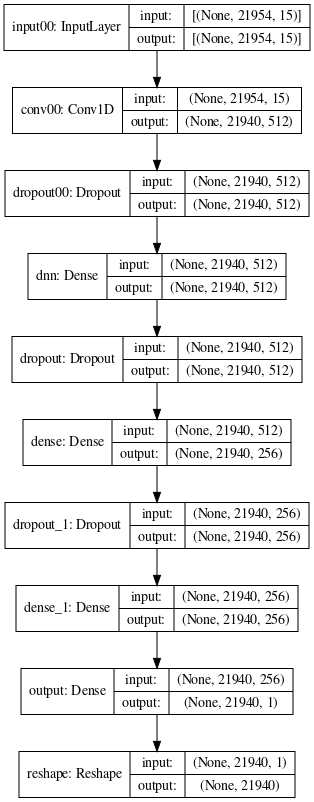

In [3]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
#model_best01a.add(Flatten())
model_best01a.add(Dense(units=1, activation=None, name="output"))
model_best01a.add(Reshape((-1,)))

plot_model(model_best01a, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True)

In [4]:
#trained_model01a = train_model(model_best01a, train3_iaq,
#                            validation_data=test3_iaq,
#                            metrics=["mse", "mae"],
#                            epochs=1, steps_per_epoch=None, 
#                            batch_size=BATCH_SIZE, base_dir=base_url)

In [5]:
#performance_plot(trained_model01a.history, metrics=['mae'])

In [8]:
base_dir = os.path.join(base_url, "models-paper.v2", model_best01a.name)
print("Saving model in: %s.h5"%base_dir)
model_best01a.save(f"{base_dir}.h5")

Saving model in: data/models-paper.v2/model_best01a.h5


In [5]:
# Inverse Transform of MinMaxScaler expects
# a shape (1, 17), we are going to do that
## b = np.zeros((1, 17))
# We set the mean scaled IAQ of the last epoch 
# on the 5th column
## b[0,4] = trained_model01a.history["val_mae"][-1]
## 
## c = scaler_f.inverse_transform(b)
## display(Markdown(f"* Mean Absolute Error in Real Scale of the last Epoch: \
## **{c[0, 4]:.4f} IAQ points**."))

In [27]:
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
dill_path = os.path.join(base_url, "models-paper.v2", 
                       "scaler-iaq.dill")
with io.open(dill_path, 'wb') as dill_file:
  print(f"Saving file: {dill_path}...", end=' ')
  dill.dump(scaler_iaq, dill_file)
  print("Done!")

Saving file: data/models-paper.v2/scaler-iaq.dill... Done!


## 5 Minute Resampling and 2 Days of History with 2 Sampling Rate.

On our previous examples this quickly becomes unmanageable the we propose skipping some records and getting the previous hour by setting the ```sampling_rate``` parameter of 10 minute.


Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=256,  seed=175904)```

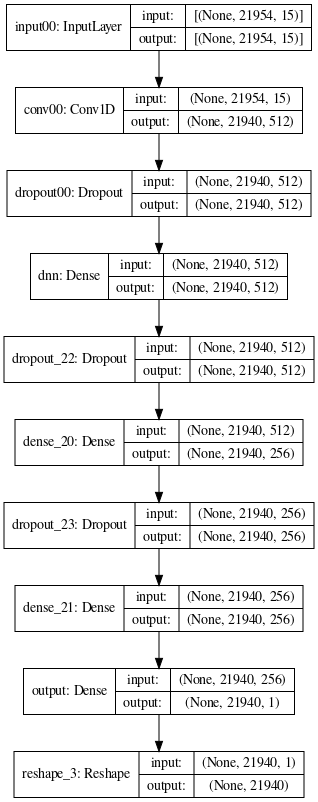

In [34]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
sampling_rate = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
#model_best01a.add(Flatten())
model_best01a.add(Dense(units=1, activation=None, name="output"))
model_best01a.add(Reshape((-1,)))

plot_model(model_best01a, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True)

In [36]:
##trained_model01a = train_model(model_best01a, train3_iaq,
##                            validation_data=test3_iaq,
##                            metrics=["mse", "mae"],
##                            epochs=1, steps_per_epoch=None##, 
##                            batch_size=BATCH_SIZE, base_dir=base_url)

In [37]:
##performance_plot(trained_model01a.history, metrics=['mae'])

In [38]:
# Inverse Transform of MinMaxScaler expects
# a shape (1, 17), we are going to do that
##b = np.zeros((1, 17))
# We set the mean scaled IAQ of the last epoch 
# on the 5th column
##b[0,4] = trained_model01a.history["val_mae"][-1]
## 
##c = scaler_f.inverse_transform(b)
##display(Markdown(f"* Mean Absolute Error in Real Scale of the last Epoch: \
##**{c[0, 4]:.4f} IAQ points**."))

## Model Baseline

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

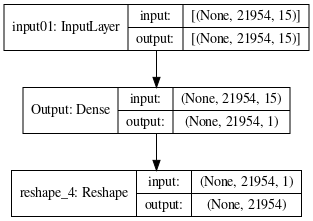

In [44]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_baseline00 = Sequential(name="model_baseline00")
model_baseline00.add(input01)
#model_baseline00.add(Dense(units=1, name="DenseNoActivation", 
#                           activation=None))
model_baseline00.add(Dense(units=1, name="Output", activation=None))
model_baseline00.add(Reshape((-1,)))
#plot_model(model_baseline00, to_file=os.path.join(base_url, "data/model.png"), 
#           dpi=72, rankdir="LR", show_shapes=True, expand_nested=True)

plot_model(model_baseline00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [47]:
# trained_model = train_model(model_baseline00, train_data=train3_iaq,
#                               validation_data=test3_iaq,
#                               metrics=["mse", "mae"],
#                               epochs=1, steps_per_epoch=None,
#                               batch_size=BATCH_SIZE)

In [46]:
base_dir = os.path.join(base_url, "models-paper.v2", model_baseline00.name)
model_baseline00.save(f"{base_dir}.h5")

## Model DNN00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

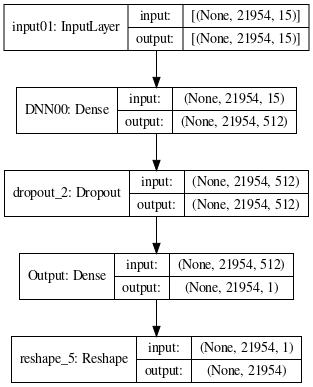

In [48]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_dnn00 = Sequential(name="model_dnn00")
model_dnn00.add(input01)
model_dnn00.add(Dense(units=512, name="DNN00"))
model_dnn00.add(Dropout(0.5))
#model_dnn00.add(Dense(units=1, name="DNN01"))
#model_dnn00.add(LSTM(units=512, name="lstm00"))
model_dnn00.add(Dense(units=1, activation=None, name="Output"))
model_dnn00.add(Reshape((-1,  )))

plot_model(model_dnn00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [49]:
trained_model = train_model(model_dnn00, train_data=train3_iaq,
                              validation_data=test3_iaq,
                              metrics=["mse", "mae"],
                              epochs=1, steps_per_epoch=None,
                              batch_size=BATCH_SIZE)

Processing Time: 42.80 seconds.


In [50]:
base_dir = os.path.join(base_url, "models-paper.v2", model_dnn00.name)
model_dnn00.save(f"{base_dir}.h5")

## Model DNN01

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=256,  seed=175904)```

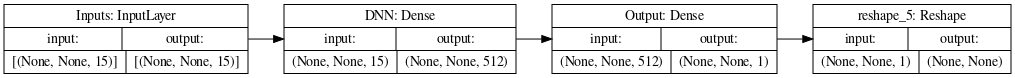

In [45]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_dnn01 = Sequential(name="model_dnn01")
model_dnn01.add(Input(shape=(None, X_train.shape[1]), name="Inputs"))
model_dnn01.add(Dense(units=512, name="DNN"))
#model_dnn01.add(Flatten())
model_dnn01.add(Dense(units=1, name="Output"))
model_dnn01.add(Reshape((-1,)))

plot_model(model_dnn01, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="LR", show_shapes=True, expand_nested=True)

In [46]:
# trained_dnn01 = train_model(model_dnn01, train3_iaq,
#                             validation_data=test3_iaq,
#                             metrics=["mse", "mae"],
#                             epochs=1, steps_per_epoch=None, 
#                             batch_size=BATCH_SIZE, base_dir=base_url)

In [47]:
base_dir = os.path.join(base_url, "models-paper.v2", model_dnn01.name)
model_dnn01.save(f"{base_dir}.h5")

In [11]:
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
dill_path = os.path.join(base_url, "models-paper.v2", 
                       "scaler-iaq.dill")
with io.open(dill_path, 'wb') as dill_file:
  print(f"Saving file: {dill_path}...", end=' ')
  dill.dump(scaler_iaq, dill_file)
  print("Done!")

Saving file: data/models-paper.v2/scaler-iaq.dill... Done!


## Model DNN02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

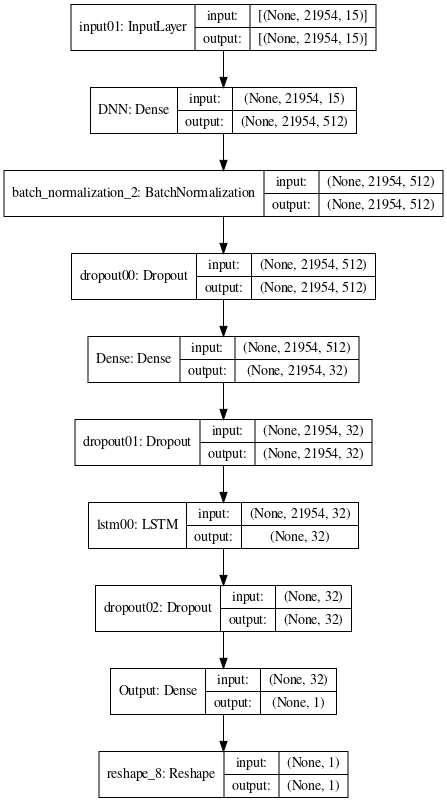

In [56]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_dnn02 = Sequential(name="model_dnn02")
model_dnn02.add(input01)
model_dnn02.add(Dense(units=512, name="DNN"))
model_dnn02.add(tf.keras.layers.BatchNormalization())
model_dnn02.add(Dropout(0.5, name="dropout00"))
model_dnn02.add(Dense(units=32, name="Dense"))
model_dnn02.add(Dropout(0.5, name="dropout01"))
model_dnn02.add(LSTM(units=32, name="lstm00"))
model_dnn02.add(Dropout(0.5, name="dropout02"))
model_dnn02.add(Dense(units=1, activation=None, name="Output"))
model_dnn02.add(Reshape((-1,  )))

plot_model(model_dnn02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [58]:
#trained_model = train_model(model_dnn02, train_data=train3_iaq,
#                              validation_data=test3_iaq,
#                              metrics=["mse", "mae"],
#                              epochs=1, steps_per_epoch=None,
#                             batch_size=BATCH_SIZE)

In [59]:
base_dir = os.path.join(base_url, "models-paper.v2", model_dnn02.name)
model_dnn02.save(f"{base_dir}.h5")

## Model Best03a

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=256,  seed=175904)```

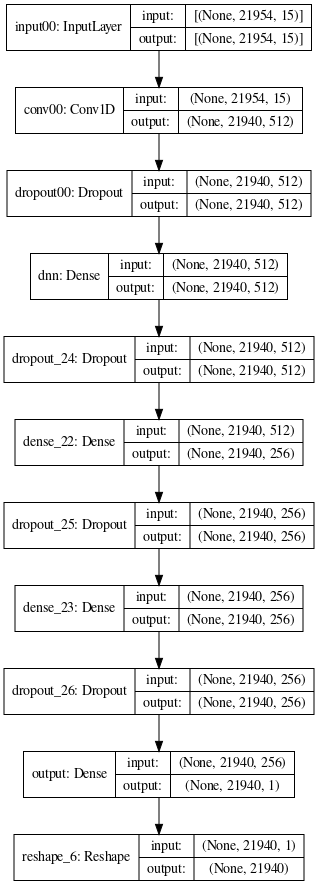

In [49]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best03a = Sequential(name="model_best03a")
model_best03a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best03a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best03a.add(Dropout(0.3, name="dropout00"))
model_best03a.add(Dense(units=512, activation='relu', name="dnn"))
model_best03a.add(Dropout(0.3))
model_best03a.add(Dense(units=256, activation='relu'))
model_best03a.add(Dropout(0.5))
model_best03a.add(Dense(units=256, activation='relu'))
model_best03a.add(Dropout(0.5))
#model_best03a.add(Flatten())
#model_best03a.add(Dense(units=1, activation=None))
#model_best03a.add(LSTM(units=1, name="lstm00"))
#model_best03a.add(Flatten())
#model_best03a.add(Reshape((-1,  )))
model_best03a.add(Dense(units=1, activation=None, name="output"))
model_best03a.add(Reshape((-1,)))
plot_model(model_best03a, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True)

In [50]:
## trained_model = train_model(model_best03a, train_data=train3_iaq,
##                               validation_data=test3_iaq,
##                               metrics=["mse", "mae"],
##                               epochs=1, steps_per_epoch=None,
##                               batch_size=BATCH_SIZE)

Processing Time: 143.22 seconds.


In [51]:
base_dir = os.path.join(base_url, "models-paper.v2", model_best03a.name)
model_best03a.save(f"{base_dir}.h5")

## Model Best03b

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

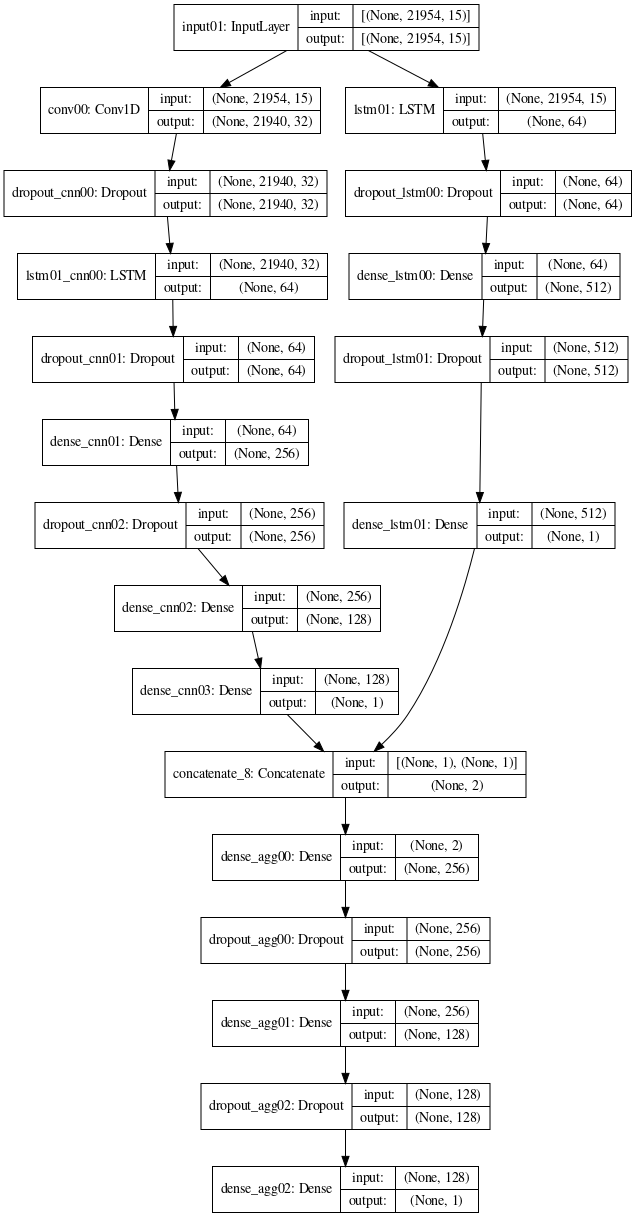

In [62]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

# LSTM Section
lstm01 = LSTM(units=64, name="lstm01")(input01)
lstm01 = Dropout(0.2, name="dropout_lstm00")(lstm01)
lstm01 = Dense(512, name="dense_lstm00", activation='relu')(lstm01)
lstm01 = Dropout(0.2, name="dropout_lstm01")(lstm01)
lstm01 = Dense(1, name="dense_lstm01")(lstm01)

# Convolutional Section
conv01 = Conv1D(32, X_train.shape[1], activation='relu', name="conv00")(input01)
conv01 = Dropout(0.5, name="dropout_cnn00")(conv01)
conv01 = LSTM(units=64, name="lstm01_cnn00")(conv01)
conv01 = Dropout(0.5, name="dropout_cnn01")(conv01)
#conv00 = Dense(512, name="dense_cnn00")(conv00)
conv01 = Dense(256, name="dense_cnn01", activation='relu')(conv01)
conv01 = Dropout(0.5, name="dropout_cnn02")(conv01)
conv01 = Dense(128, name="dense_cnn02", activation='relu')(conv01)
#conv00 = tf.keras.layers.Flatten(name="flatten_cnn00")(conv00)
conv01 = Dense(1, name="dense_cnn03")(conv01)

# Merge Layers
concat01 = tf.keras.layers.concatenate([lstm01, conv01])

pred01 = Dense(256, name="dense_agg00")(concat01)
pred01 = Dropout(0.5, name="dropout_agg00")(pred01)
pred01 = Dense(128, name="dense_agg01")(pred01)
pred01 = Dropout(0.5, name="dropout_agg02")(pred01)
pred01 = Dense(1, name="dense_agg02")(pred01)

# Create a Model that tights everythin' together
model_best03b = Model(
    inputs=[input01],
    outputs=[pred01],
    name="model_best03b"
)
plot_model(model_best03b, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

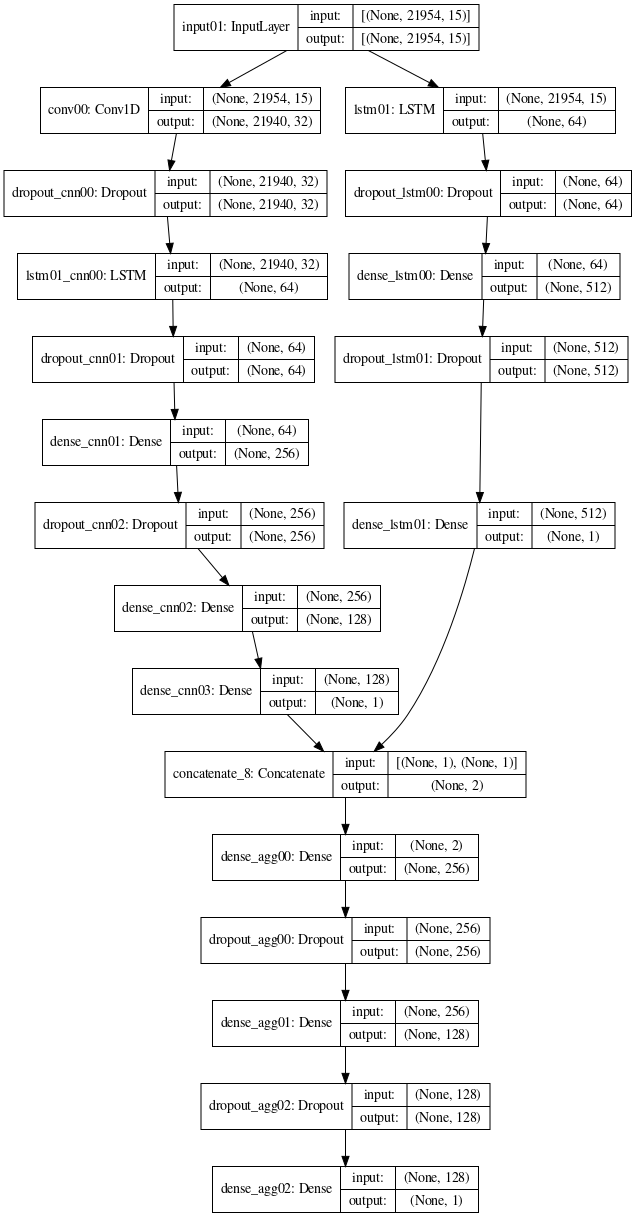

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

InvalidArgumentError:    Operation expected a list with 21940 elements but got a list with 2146 elements.
	 [[{{node gradients/TensorArrayUnstack/TensorListFromTensor_grad/TensorListStack}}]]
	 [[Adam/gradients/PartitionedCall_1]] [Op:__inference_train_function_81439]

Function call stack:
train_function -> train_function -> train_function


In [63]:
trained_model = train_model(model_best03b, train_data=train3_iaq,
                              validation_data=test3_iaq,
                              metrics=["mse", "mae"],
                              epochs=1, steps_per_epoch=None,
                              batch_size=BATCH_SIZE)

In [65]:
base_dir = os.path.join(base_url, "models-paper.v2", model_best03b.name)
model_best03b.save(f"{base_dir}.h5")

## Model LSTM00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

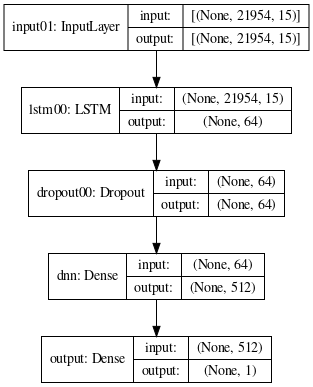

In [22]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_lstm00 = Sequential(name="model_lstm00")
model_lstm00.add(input01)
model_lstm00.add(LSTM(units=64, name="lstm00"))
model_lstm00.add(Dropout(0.5, name="dropout00"))
model_lstm00.add(Dense(units=512, activation='relu', name="dnn"))
model_lstm00.add(Dense(units=1, activation=None, name="output"))
model_lstm00.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

plot_model(model_lstm00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [24]:
# trained_model = train_model(model_lstm00, train_data=train3_iaq,
#                               validation_data=test3_iaq,
#                               metrics=["mse", "mae"],
#                               epochs=1, steps_per_epoch=None,
#                               batch_size=BATCH_SIZE)

In [25]:
base_dir = os.path.join(base_url, "models-paper.v2", model_lstm00.name)
model_lstm00.save(f"{base_dir}.h5")

## Model LSTM02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

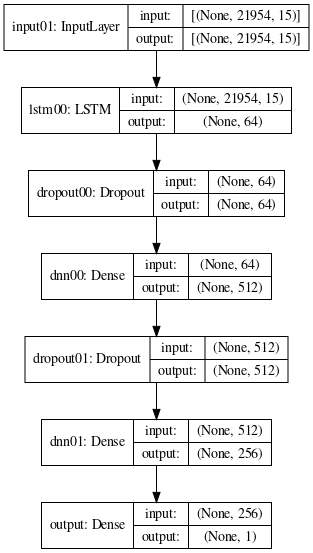

In [28]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_lstm02 = Sequential(name="model_lstm02")
model_lstm02.add(input01)
model_lstm02.add(LSTM(units=64, name="lstm00"))
model_lstm02.add(Dropout(0.2, name="dropout00"))
model_lstm02.add(Dense(units=512, activation='relu', name="dnn00"))
model_lstm02.add(Dropout(0.2, name="dropout01"))
model_lstm02.add(Dense(units=256, activation='relu', name="dnn01"))
model_lstm02.add(Dense(units=1, activation=None, name="output"))

plot_model(model_lstm02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [30]:
# trained_model = train_model(model_lstm02, train_data=train3_iaq,
#                               validation_data=test3_iaq,
#                               metrics=["mse", "mae"],
#                               epochs=1, steps_per_epoch=None,
#                               batch_size=BATCH_SIZE)

In [31]:
base_dir = os.path.join(base_url, "models-paper.v2", model_lstm02.name)
model_lstm02.save(f"{base_dir}.h5")

## Model Conv00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  batch_size=64,  seed=175904)```

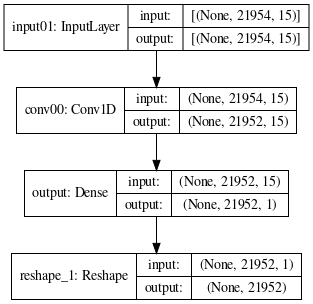

In [34]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_conv00 = Sequential(name="model_conv00")
model_conv00.add(input01)
model_conv00.add(Conv1D(filters=15, kernel_size=3, activation='relu',
                        name="conv00"))
#model_conv00.add(LSTM(units=15, name="lstm00"))
model_conv00.add(Dense(units=1, activation=None, name="output"))
model_conv00.add(Reshape((-1,)))
model_conv00.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

plot_model(model_conv00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [36]:
# trained_model = train_model(model_conv00, train_data=train3_iaq,
#                               validation_data=test3_iaq,
#                               metrics=["mse", "mae"],
#                               epochs=1, steps_per_epoch=None,
#                               batch_size=BATCH_SIZE)

In [37]:
base_dir = os.path.join(base_url, "models-paper.v2", model_conv00.name)
model_conv00.save(f"{base_dir}.h5")

## Model Conv02

```data.shape=(31364, 20)```

```train.shape=(21954, 17)```

```train2.shape=(21954, 17)```

```X_train.shape=(21954, 15)```

```Y_train.shape=(21954, 2)```

```X_test.shape=(9410, 15)```

```Y_test.shape=(9410, 2)```

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=2160,  sampling_rate=2,  stride=2,  batch_size=64,  seed=175904)```

```test3_iaq.shape=40```

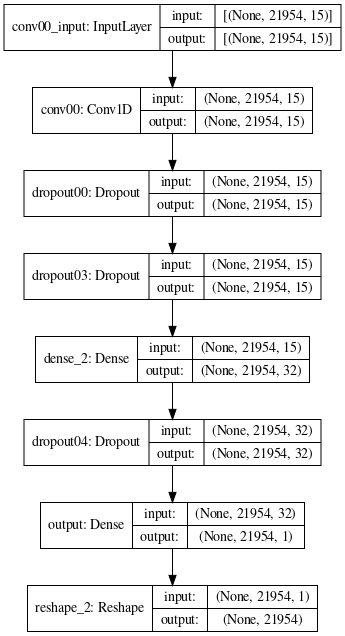

In [38]:
# Data Prep
WINDOW_SIZE_DAYS = 15
stride = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

display(Markdown(f"```data.shape={data.shape}```"))
display(Markdown(f"```train.shape={train.shape}```"))
display(Markdown(f"```train2.shape={train2.shape}```"))
display(Markdown(f"```X_train.shape={X_train.shape}```"))
display(Markdown(f"```Y_train.shape={Y_train.shape}```"))
display(Markdown(f"```X_test.shape={X_test.shape}```"))
display(Markdown(f"```Y_test.shape={Y_test.shape}```"))

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 2
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  stride={stride},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

display(Markdown(f"```test3_iaq.shape={len(test3_iaq)}```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_conv02 = Sequential(name="model_conv02")
#model_conv02.add(input01)
model_conv02.add(Conv1D(filters=15, kernel_size=3, activation='relu', 
                        input_shape=(X_train.shape[0], X_train.shape[1]),
                        padding='same', name="conv00"))
#model_conv02.add(tf.keras.layers.MaxPooling1D(pool_size=256, name="maxp00"))
#model_conv02.add(Flatten())
model_conv02.add(Dropout(0.3, name="dropout00"))
##model_conv02.add(Dense(units=512, activation='relu', name="dnn00"))
##model_conv02.add(Dropout(0.3, name="dropout01"))
###
##model_conv02.add(Conv1D(filters=1, kernel_size=3, activation='relu', 
##                        padding='same', name="conv01"))
#model_conv02.add(tf.keras.layers.MaxPooling1D(pool_size=256, name="maxp01"))
#model_conv02.add(tf.keras.layers.Reshape(target_shape=(169, )))
##model_conv02.add(Dropout(0.3, name="dropout02"))
###
#model_conv02.add(Dropout(0.5))
#model_conv02.add(Flatten(name="flatten00"))
#model_conv02.add(LSTM(units=64, name="lstm00"))
model_conv02.add(Dropout(0.3, name="dropout03"))
model_conv02.add(Dense(units=32, activation='relu'))
model_conv02.add(Dropout(0.3, name="dropout04"))
model_conv02.add(Dense(units=1, activation=None, name="output"))
model_conv02.add(Reshape((-1,)))

model_conv02.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

plot_model(model_conv02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [41]:
# trained_model = train_model(model_conv02, train_data=train3_iaq,
#                               validation_data=test3_iaq,
#                               metrics=["mse", "mae"],
#                               epochs=1, steps_per_epoch=None,
#                               batch_size=BATCH_SIZE)

In [40]:
base_dir = os.path.join(base_url, "models-paper.v2", model_conv02.name)
model_conv02.save(f"{base_dir}.h5")

# References

* [Tensorflow on Numpy 1.20.0](https://github.com/tensorflow/models/issues/9706#issuecomment-791113516)